2024-12-03 22:03:03.879139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:03:03.903839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:03:03.910489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available GPUs: []
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



2024-12-03 22:03:08.154650: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Total dataset size:  467530
Signal dataset size:  223950
Background dataset size:  243580
Training dataset size:  374024
Validation dataset size:  93506
Number of training batches:  5845
Number of validation batches:  1462
Input shape:  (None, 31)


NameError: name 'å' is not defined

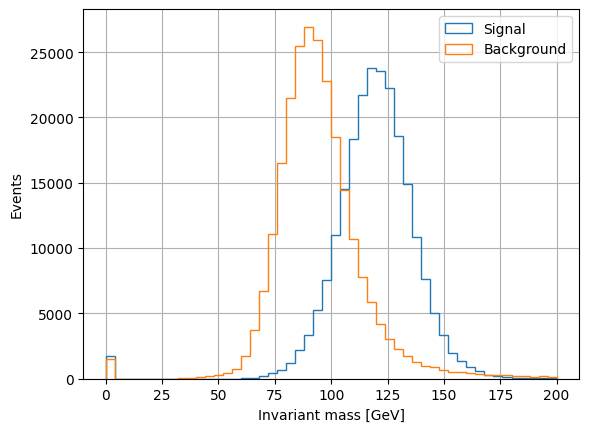

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Import tensorflow and test if GPU is available
import tensorflow as tf
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
! nvidia-smi 

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read data using pandas
dataframe_higgs = pd.read_csv("/scratch/ucjf-atlas/njsf164/data_higgs.csv")

# split the data into signal and background dataframes for plotting purposes. 
# The signal/background can be distinguished by the first column of the csv file, which is called "label".
# The signal is defined by the label being 1, the background by the label being 0

sig_dataframe_higgs = dataframe_higgs[dataframe_higgs['label'] == 1]
bkg_dataframe_higgs = dataframe_higgs[dataframe_higgs['label'] == 0]

# draw example picture of the signal and background particle invariant mass to see if we loaded the data correctly
sig_dataframe_higgs['ditau_mmc_mlm_m'].hist(bins=50, range=(0,200), histtype='step', label='Signal')
bkg_dataframe_higgs['ditau_mmc_mlm_m'].hist(bins=50, range=(0,200), histtype='step', label='Background')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()

# list of features (variables) we want to use for classification
variables_higgs = [  
    "tau_0_p4.Pt","tau_0_p4.Eta","tau_0_p4.Phi",
    "tau_1_p4.Pt","tau_1_p4.Eta","tau_1_p4.Phi",
    "ditau_deta","ditau_dphi","ditau_dr","ditau_higgspt","ditau_scal_sum_pt", #"ditau_mmc_mlm_m",
    "jet_0_p4.Pt","jet_0_p4.Eta","jet_0_p4.Phi",
    "jet_1_p4.Pt","jet_1_p4.Eta","jet_1_p4.Phi",
    "dijet_p4.Pt","dijet_p4.Eta","dijet_p4.Phi","dijet_p4.M","dijet_dPhi","dijet_dr","jet_0_p4.Eta-jet_1_p4.Eta",
    "met_p4.Pt", "n_jets","n_jets_30","n_jets_40","n_electrons","n_muons","n_taus",
]

# The dataset is composed from a tuple of two tensors: (features, label)
dataset_higgs = tf.data.Dataset.from_tensor_slices((dataframe_higgs[variables_higgs].to_numpy(), dataframe_higgs['label'].to_numpy()))

# we also create separate datasets for signal and background to be used for model evaluation. These do not need the "label" column
sig_dataset_higgs = tf.data.Dataset.from_tensor_slices(sig_dataframe_higgs[variables_higgs].to_numpy())
bkg_dataset_higgs = tf.data.Dataset.from_tensor_slices(bkg_dataframe_higgs[variables_higgs].to_numpy())

# cash the dataset sizes
dataset_size_higgs = len(dataframe_higgs)
sig_size_higgs = len(sig_dataframe_higgs)
bkg_size_higgs = len(bkg_dataframe_higgs)
print("Total dataset size: ", dataset_size_higgs)
print("Signal dataset size: ", sig_size_higgs)
print("Background dataset size: ", bkg_size_higgs)

train_fraction_higgs = 0.8
train_size_higgs = int(train_fraction_higgs * dataset_size_higgs)
val_size_higgs = dataset_size_higgs - train_size_higgs

# take the first train_size_higgs observations for training
train_dataset_higgs = dataset_higgs.take(train_size_higgs)

# the rest will be used for validation
val_dataset_higgs = dataset_higgs.skip(train_size_higgs)

# training dataset size:
print("Training dataset size: ", len(train_dataset_higgs))
print("Validation dataset size: ", len(val_dataset_higgs))

# batch the data
# NOTE: Larger the batch size, more memory is used. If you don't have enough memory, make the batch smaller.
#       However, the training will be slower.
batch_size_higgs = 64
train_dataset_higgs = train_dataset_higgs.batch(batch_size_higgs)
val_dataset_higgs = val_dataset_higgs.batch(batch_size_higgs)

# print the number of training and validation batches
print("Number of training batches: ", len(train_dataset_higgs))
print("Number of validation batches: ", len(val_dataset_higgs))

# The following function just picks data tensor from the (data, label) dataset
#  This is needed to calculate the mean and variance of the data
@tf.function
def pick_only_data(data, label):
    return data

## Extract the number of variables in the NN input. In this example we know it's 32, but let's show how to do it 
## with he tf.data.Dataset class:
inputShape = train_dataset_higgs.element_spec[0].shape  # this returns the input tensor shape including the batch dimension
print("Input shape: ", inputShape)

# here we start to build the network
# we utilize the so called 'functional API' (https://www.tensorflow.org/guide/keras/functional)


# 1/ INPUT LAYER: needs to know the shape of an sample, here we omit the batch dimension
input = tf.keras.layers.Input(shape=inputShape[1:])

# 2/ NORMALIZATION LAYER: we use the normalizer layer we created before. 
# The "normalizer" object is called as a function on the output from the previous layer
## calculate the mean and variance of the training dataset variables and setup the norm. layer
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(train_dataset_higgs.map(pick_only_data))
layer = normalizer(input)

# 3/ DENSE LAYER: a single fully connected layer with sigmoid activation
dense = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
output = 

# here we create the model with input and output
model_higgs = tf.keras.Model(inputs=input, outputs=output)

# we need to compile the model, ie. to specify the loss we want to minimize,
# optimizer (which is used to minimize the loss) and metrics (which are used to evaluate the model)
# in our case we use the binary cross-entropy loss, which is good for binary classification
# we use the Adam optimizer, which is a good default choice
# we use the accuracy metric, which is just the fraction of correct predictions
model_higgs.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# here we print the model summary, outline
model_higgs.summary()

# this is the part where the training happens, we specify the number of epochs we want to train for and validation dataset
# validation will happen after each epoch
epochs = 10
history = model_higgs.fit(train_dataset_higgs, epochs=epochs, validation_data=val_dataset_higgs)

# plot the training history
plt.figure("higgs_history_loss")
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of logistic regression model')
plt.legend()

plt.figure("higgs_history_accuracy")
plt.plot(history.history['val_binary_accuracy'], label='val binary_accuracy')
plt.plot(history.history['binary_accuracy'], label='train binary_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of logistic regression model')
plt.legend()

# Filter signal and background events from validation dataset using `filter` method.
# NOTE: we need to unbatch the dataset before filtering, because the filter function expects a single observation, not a batch.
# NOTE 2: using lambda functions in this was is not very efficient. For large datasets, we should define
# the filtering function using `def` and `@tf.function` decorator like we do for `pick_only_data` function.
y_sig = model_higgs.predict(val_dataset_higgs.unbatch().filter(lambda x, label: label == 1).map(pick_only_data).batch(1024))
y_bkg = model_higgs.predict(val_dataset_higgs.unbatch().filter(lambda x, label: label == 0).map(pick_only_data).batch(1024))

y_sig_train = model_higgs.predict(train_dataset_higgs.unbatch().filter(lambda x, label: label == 1).map(pick_only_data).batch(1024))
y_bkg_train = model_higgs.predict(train_dataset_higgs.unbatch().filter(lambda x, label: label == 0).map(pick_only_data).batch(1024))

plt.figure("higgs_output")
plt.hist(y_sig, bins=100, range=(0, 1), histtype='step', label='signal', density=True)
plt.hist(y_bkg, bins=100, range=(0, 1), histtype='step', label='background', density=True)
plt.hist(y_sig_train, bins=100, range=(0, 1), histtype='step', label='signal_train', density=True)
plt.hist(y_bkg_train, bins=100, range=(0, 1), histtype='step', label='background_train', density=True)

plt.xlabel("Model output")
plt.ylabel("Events")
plt.legend()


# perform evaluation of the model again using train and validation datasets
# we use the `evaluate` method of the model object
# this method returns the loss and metrics values
metrices_train = model_higgs.evaluate(train_dataset_higgs)
metrices_val = model_higgs.evaluate(val_dataset_higgs)

print("")
print("Overfitting check:")
print("")
for name, value_train, value_val in zip(model_higgs.metrics_names, metrices_train, metrices_val):
    print(name, "train:", value_train, "val:", value_val)
